### Import Libraries

In [1]:
import os 
import torch 
import torch.nn as nn
import torchmetrics
import torchvision
from torchvision.transforms import transforms
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split

import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pneumonia_dataset import PneumoniaDataset

### Data Preperation

In [2]:
# Define the data directories and labels file
data_dir = "Data/rsna-pneumonia-detection-challenge/stage_2_train_images/"
labels = "Data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"

In [3]:
# Read in data 
labels_df = pd.read_csv(labels)
labels_df.shape

(30227, 6)

In [4]:
labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [5]:
labels_df = labels_df[["patientId", "Target"]]
labels_df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [6]:
# Data transormation pipelines for data preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.25, 1), antialias=True)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [7]:
# Define variables
batch_size = 32
num_workers = 4

# Split the labels into train and validation sets
train_labels, val_labels = train_test_split(labels_df.values, test_size=0.1, random_state=42)


# Get the paths for train and validation images
train_paths = [os.path.join(data_dir, image[0] + ".dcm") for image in train_labels]
val_paths = [os.path.join(data_dir, image[0] + ".dcm") for image in val_labels]


# Create train dataset
train_dataset = PneumoniaDataset(train_paths, train_labels[:, 1], transforms=train_transforms)

# Create validation dataset
val_dataset = PneumoniaDataset(val_paths, val_labels[:, 1], transforms=val_transforms)

##### Preview images

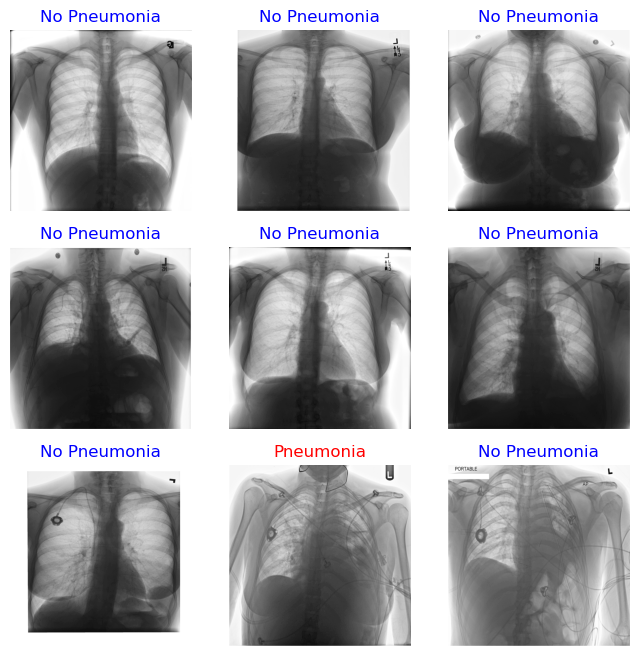

In [8]:
# Create a 3x3 grid for image preview
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.grid(False)
    
    img_dcm = pydicom.dcmread(f'{train_paths[i+20]}')
    img_np = img_dcm.pixel_array
    plt.imshow(img_np, cmap=plt.cm.binary)

    if train_labels[i+20][1] == 1:
        plt.title("Pneumonia", color="red")
    else:
        plt.title("No Pneumonia", color="blue")

    plt.axis("off")

In [9]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True
) 

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)     



### Create Model

In [10]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=3):
        super().__init__()
        # Define the model architecture
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        y = y.float().unsqueeze(1)  # Ensure target tensor has the same size as input tensor
        loss = self.loss_fn(outputs, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", self.train_acc(outputs.sigmoid(), y), on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        y = y.float().unsqueeze(1)  # Ensure target tensor has the same size as input tensor
        loss = self.loss_fn(outputs, y)
        self.log("val_loss", loss, on_step=True, on_epoch=True)
        self.log("val_acc", self.val_acc(outputs.sigmoid(), y), on_step=True, on_epoch=True)

    def configure_optimizers(self):
        return self.optimizer


In [11]:
# Create checkpoint
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    dirpath="./models",
    filename="best_model",
    save_top_k=1,
    mode="max"
)

In [12]:
# Initialize the model
model = PneumoniaModel()

In [13]:
# Create PyTorch Lighting Trainer
trainer = pl.Trainer(
    devices=1,
    accelerator="gpu",
    logger=TensorBoardLogger(save_dir="./logs"), 
    log_every_n_steps=1,
    callbacks=checkpoint_callback,
    max_epochs=10
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(
    model,
    train_loader,
    val_loader
)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | Sequential        | 27.3 K
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
27.3 K    Trainable params
0         Non-trainable params
27.3 K    Total params
0.109     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]